In [1]:
# pip install langdetect emoji matplotlib seaborn pandas nltk wordcloud kagglehub scikit-learn plotly nbformat varclushi cufflinks
# El conjunto de datos se decargo de Kagglehub:https://www.kaggle.com/datasets/kanchana1990/whatsapp-business-reviews-app-store?resource=download

# Importar librerias y paquetes

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd
import seaborn as sns

# Data Correlation
from varclushi import VarClusHi

#Data Languaje
from langdetect import detect, detect_langs
from langdetect.lang_detect_exception import LangDetectException
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LinearRegression, LogisticRegression, SGDClassifier, SGDRegressor

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, accuracy_score, confusion_matrix,classification_report

In [3]:
nltk.download("vader_lexicon")
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juanmi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Definición de funciones

In [4]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

In [5]:
def normalize(df, features):
    for feature in features:
        aux = df[feature].value_counts(True)
        ls_categories = [category for category, freq in aux.items() if freq > 0.05]
        df[feature] = df[feature].map(lambda x: x if x in ls_categories else "Others")
    return df

In [6]:
def detectar(texto):
  try:
    return detect(texto)
  except:
    return "unknown"

In [7]:
def limpieza(df, col):
  df[col] = (
      df[col]
      .astype(str)
      .str.replace(r"[\n\r\t]", " ", regex=True)
      .str.replace(":", " ", regex=False)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
  )
  return df

In [8]:
def remove_emojis(text):
  if not isinstance(text, str):
    return text
  return emoji.replace_emoji(text, replace="")

# Importar dataset

In [9]:
df = pd.read_csv("./content/hashed_wab_reviews.csv")

# EDA

In [10]:
df = df.replace('', np.nan)

In [11]:
dfCopy = df.copy()

In [12]:
dfCopy.head(3)

id                       date  \
0  10990027692  2024-02-28T13:15:16-07:00   
1  10939311897  2024-02-14T14:47:02-07:00   
2  10932303253  2024-02-12T15:54:56-07:00   

                                            userName  \
0  a71209417cc69068db96287dcfa258e84a19b36c443521...   
1  9f7302dde70e971b057aa14cec1d26479a9362da32e9ed...   
2  ee939200223a21c2bdea5d17ef0ae2d9a03acfbb914c73...   

                                             userUrl  version  score  \
0  c6434d50f03dc3225343d08cb75b120e19dc21937007da...  24.4.78      1   
1  55105d432b1d6c664523f5de2576a199f8ffa8d8c20e8a...  24.3.76      2   
2  1c044d9599692ebd0d50f4fb8d886f622ee02c549d76f8...  24.3.76      4   

             title                                               text  \
0    Status sounds  No sound comes from status videos after I upda...   
1            Calls  Every time I’m on a phone call, it either cut ...   
2  Recommendations  I like being to have a separate account/app fo...   

                                                 url country       appId  
0  https://itunes.apple.com/au/review?id=13864129...      AU  1386412985  
1  https://itunes.apple.com/au/review?id=13864129...      AU  1386412985  
2  https://itunes.apple.com/au/review?id=13864129...      AU  1386412985

In [13]:
dfCopy.shape

(1459, 11)

In [14]:
dfCopy.describe()

id        score         appId
count  1.459000e+03  1459.000000  1.459000e+03
mean   9.372247e+09     3.133653  1.386413e+09
std    1.782619e+09     1.764405  0.000000e+00
min    3.993157e+09     1.000000  1.386413e+09
25%    8.411967e+09     1.000000  1.386413e+09
50%    1.028037e+10     3.000000  1.386413e+09
75%    1.065195e+10     5.000000  1.386413e+09
max    1.101599e+10     5.000000  1.386413e+09

In [15]:
dfCopy.columns

Index(['id', 'date', 'userName', 'userUrl', 'version', 'score', 'title',
       'text', 'url', 'country', 'appId'],
      dtype='object')

In [16]:
dfCopy = dfCopy.drop(columns = ["userUrl", "url"])

In [17]:
dfCopy.dtypes

id           int64
date        object
userName    object
version     object
score        int64
title       object
text        object
country     object
appId        int64
dtype: object

In [18]:
dfCopy["date"] = pd.to_datetime(dfCopy["date"], errors="coerce")

In [19]:
dfCopy["date"].iloc[0]

Timestamp('2024-02-28 13:15:16-0700', tz='UTC-07:00')

In [20]:
dfCopy["dateCompleta"] = dfCopy["date"].dt.date
dfCopy["year"] = dfCopy["date"].dt.year
dfCopy["month"] = dfCopy["date"].dt.month
dfCopy["day"] = dfCopy["date"].dt.day
dfCopy["time"] = dfCopy["date"].dt.time

In [21]:
dfCopy.columns

Index(['id', 'date', 'userName', 'version', 'score', 'title', 'text',
       'country', 'appId', 'dateCompleta', 'year', 'month', 'day', 'time'],
      dtype='object')

In [22]:
dfCopy = dfCopy[["id", "dateCompleta", "date", "year", "month", "day", "time", "country", "userName", "appId", "version", "score", "title", "text"]]

In [23]:
dfCopy["country"].unique()

array(['AU', 'LK', 'CA', 'US'], dtype=object)

In [24]:
dfCopy["country"].value_counts()

country
LK    552
US    500
CA    290
AU    117
Name: count, dtype: int64

In [25]:
dfCopy["appId"].unique()

array([1386412985])

In [26]:
dfCopy["version"].value_counts()

version
23.25.86    114
23.23.82     88
23.23.79     70
24.2.75      55
24.1.80      48
           ... 
23.10.77      1
22.7.78       1
2.20.120      1
2.20.111      1
23.11.78      1
Name: count, Length: 148, dtype: int64

In [27]:
dfCopy["score"].unique()

array([1, 2, 4, 5, 3])

In [28]:
dfCopy["title"].isna().sum()

np.int64(0)

In [29]:
dfCopy["title"] = dfCopy["title"].str.lower()

In [30]:
dfCopy["text"].isna().sum()

np.int64(0)

In [31]:
dfCopy["text"] = dfCopy["text"].str.lower()

In [32]:
"""
es español
en ingles
fr frances
pt portugues
de aleman
ru ruso
it italiano
cs checo
"""

'\nes español\nen ingles\nfr frances\npt portugues\nde aleman\nru ruso\nit italiano\ncs checo\n'

In [33]:
dfCopy.loc[dfCopy["title"] == "10/10", "title"] = "great service"
dfCopy.loc[dfCopy["title"] == "🙂", "title"] = "great service"
dfCopy.loc[dfCopy["title"] == "???", "title"] = "confused"
dfCopy.loc[dfCopy["title"] == "🤦🤦", "title"] = "error"
dfCopy.loc[dfCopy["title"] == "😡", "title"] = "bad"

In [34]:
dfCopy["idioma_title"] = dfCopy["title"].apply(detectar)

In [35]:
dfCopy["idioma_title"].value_counts()

idioma_title
en         754
af          75
fr          64
so          56
tl          52
it          50
es          39
ro          29
cy          27
ar          26
ca          24
id          22
et          21
no          19
da          19
pt          19
cs          18
nl          17
sl          13
sw          13
hr          13
unknown     12
sv          12
fi          11
pl          11
sk           8
lt           7
de           5
ur           5
lv           4
sq           3
tr           2
mk           2
ru           2
zh-cn        1
vi           1
hu           1
fa           1
he           1
Name: count, dtype: int64

In [36]:
dfCopy["idioma_texto"] = dfCopy["text"].apply(detectar)

In [37]:
dfCopy["idioma_texto"].value_counts()

idioma_texto
en         1164
es           51
fr           42
ar           28
so           25
af           19
unknown      17
ca           13
pl            9
id            8
hr            7
nl            7
cy            6
no            6
ru            6
pt            5
cs            4
it            4
sk            4
tl            4
ur            3
fa            3
ro            3
sq            2
sw            2
da            2
sl            2
sv            2
tr            2
fi            2
pa            1
de            1
ko            1
et            1
lv            1
he            1
lt            1
Name: count, dtype: int64

In [38]:
dfCopy[["idioma_title", "idioma_texto"]]

idioma_title idioma_texto
0              en           en
1              ca           en
2              fr           en
3              en           en
4              en           en
...           ...          ...
1454           ar           ar
1455           af           en
1456           ar           ar
1457           es           es
1458           pt           pt

[1459 rows x 2 columns]

In [39]:
#dfCopy[dfCopy["idioma_title"] == dfCopy["idioma_texto"]]

In [40]:
dfCopy["title"] = (dfCopy["title"].str.replace(r"^subject\s*", "", regex=True))

In [41]:
(dfCopy["title"] != dfCopy["title"].str.strip()).value_counts()

title
False    1459
Name: count, dtype: int64

In [42]:
(dfCopy["title"].str.contains(r"[^\x00-\x7F]", regex=True)).sum()
dfCopy.loc[dfCopy["title"].str.contains(r"[\x00-\x7F]", regex=True)]

id dateCompleta                      date  year  month  day  \
0     10990027692   2024-02-28 2024-02-28 13:15:16-07:00  2024      2   28   
1     10939311897   2024-02-14 2024-02-14 14:47:02-07:00  2024      2   14   
2     10932303253   2024-02-12 2024-02-12 15:54:56-07:00  2024      2   12   
3     10859859638   2024-01-24 2024-01-24 12:47:22-07:00  2024      1   24   
4     10758670982   2023-12-29 2023-12-29 05:13:49-07:00  2023     12   29   
...           ...          ...                       ...   ...    ...  ...   
1454  10496943118   2023-10-20 2023-10-20 14:19:43-07:00  2023     10   20   
1455  10496461023   2023-10-20 2023-10-20 11:11:05-07:00  2023     10   20   
1456  10496331338   2023-10-20 2023-10-20 10:24:15-07:00  2023     10   20   
1457  10496216785   2023-10-20 2023-10-20 09:44:47-07:00  2023     10   20   
1458  10495941296   2023-10-20 2023-10-20 08:17:10-07:00  2023     10   20   

          time country                                           userName  \
0     13:15:16      AU  a71209417cc69068db96287dcfa258e84a19b36c443521...   
1     14:47:02      AU  9f7302dde70e971b057aa14cec1d26479a9362da32e9ed...   
2     15:54:56      AU  ee939200223a21c2bdea5d17ef0ae2d9a03acfbb914c73...   
3     12:47:22      AU  10c5a49c9a79ddf4cd973abd6f125b5bf98d9e6cf22fbd...   
4     05:13:49      AU  83481ba5686098a9f7b2b9e374dc5ed7a3627bcd5eb28f...   
...        ...     ...                                                ...   
1454  14:19:43      US  02c651efe913547d1a0004103f605c7c20fdc9f8cc384d...   
1455  11:11:05      US  f4be00febd0851047acce181b885b8f759dbe597f90160...   
1456  10:24:15      US  325d8d5a6fc96d2f647943c3a73fd363a865a79991d9d7...   
1457  09:44:47      US  4ae4744cb80d9d0c42c8b7a4807fd72307263d2d06d52b...   
1458  08:17:10      US  920aa659c9fecbd3b4da56b4d5099c3e40bb499bda468b...   

           appId   version  score  \
0     1386412985   24.4.78      1   
1     1386412985   24.3.76      2   
2     1386412985   24.3.76      4   
3     1386412985   24.1.80      5   
4     1386412985  23.25.86      2   
...          ...       ...    ...   
1454  1386412985  23.21.70      1   
1455  1386412985  23.21.70      5   
1456  1386412985  23.21.70      5   
1457  1386412985  23.21.70      1   
1458  1386412985  23.21.70      1   

                                                  title  \
0                                         status sounds   
1                                                 calls   
2                                       recommendations   
3     : request for premium features in whatsapp aus...   
4                                     not satisfied yet   
...                                                 ...   
1454                                    مفيش حرية تعبير   
1455                                      wassap review   
1456                                         افضل تطبيق   
1457                                          se cierra   
1458               não está abrindo o whatsapp business   

                                                   text idioma_title  \
0     no sound comes from status videos after i upda...           en   
1     every time i’m on a phone call, it either cut ...           ca   
2     i like being to have a separate account/app fo...           fr   
3     dear whatsapp support team,\n\ni hope this mes...           en   
4     only seems like someone clicks on your ad when...           en   
...                                                 ...          ...   
1454                                    مفيش حرية تعبير           ar   
1455                                       satisfactory           af   
1456  افضل تطبيق تواصل بلا منازع و خاصة بعد التحديثا...           ar   
1457  la app se me cierra sola al momento de enviar ...           es   
1458  meu whatsapp business não está abrindo e nem c...           pt   

     idioma_texto  
0              en  
1              en  
2              en  
3              en  
4              en  
...           

In [43]:
dfCopy["title"] = (
    dfCopy["title"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

In [44]:
dfCopy["text"] = (
    dfCopy["text"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

In [45]:
dfCopy = limpieza(dfCopy, "title")

In [46]:
dfCopy = limpieza(dfCopy, "text")

In [47]:
dfCopy["text"] = dfCopy["text"].apply(remove_emojis)
dfCopy["title"] = dfCopy["title"].apply(remove_emojis)

In [48]:
#dfCopy = dfCopy[~((dfCopy["idioma_title"] == "ar") & (dfCopy["idioma_texto"] == "ar"))]

In [49]:
# Notamos que hay coasos en los que el texto si lo detecta como ingles pero el titulo no, 
# por lo que filtramos para quedarnos con los que al menos uno de los dos es ingles, y no esten vacios.
dfCopy = dfCopy[(dfCopy["idioma_texto"] == "en") & (dfCopy["idioma_title"] == "en")]

In [50]:
dfCopy.shape

(709, 16)

In [51]:
dfCopy.sample(5)

id dateCompleta                      date  year  month  day  \
381   10671368056   2023-12-08 2023-12-08 11:07:44-07:00  2023     12    8   
719    6524282661   2020-10-11 2020-10-11 07:56:14-07:00  2020     10   11   
1260  10643771222   2023-11-30 2023-11-30 17:44:50-07:00  2023     11   30   
1074   7470884735   2021-06-16 2021-06-16 05:09:01-07:00  2021      6   16   
5     10745591318   2023-12-25 2023-12-25 21:11:41-07:00  2023     12   25   

          time country                                           userName  \
381   11:07:44      CA  1bc4cbe9bd017982964588e0adc2b7f8f64ad59f1d972d...   
719   07:56:14      CA  ff2eb7ccb5bf7872a00b19130345c260bc23c76d638e02...   
1260  17:44:50      US  986638507f78d02b61843f96e443b3d9df952f88d0c6db...   
1074  05:09:01      LK  564237f390e62afe904d7e763039d72328ded6e1f7022a...   
5     21:11:41      AU  abf9040f6eec5c83ff0cabb20346274caa6b8d81102343...   

           appId   version  score                            title  \
381   1386412985  23.24.73      1                   one click view   
719   1386412985  2.20.102      1                            crash   
1260  1386412985  23.23.82      4           archive of group chats   
1074  1386412985  2.21.110      3  pls make easy label chat method   
5     1386412985  23.25.86      5                        great app   

                                                   text idioma_title  \
381   open one click search media needed is difficul...           en   
719                                 crashing in ios 142           en   
1260  why cant i archive a group chat with an announ...           en   
1074  it is too late to our business customer to lab...           en   
5                  easy to use great app very effective           en   

     idioma_texto  
381            en  
719            en  
1260           en  
1074           en  
5              en

In [52]:
dfCopy.loc[dfCopy["score"] >= 3, "scoreCat"] = "buena"
dfCopy.loc[dfCopy["score"] < 3, "scoreCat"] = "mala"

In [53]:
sia = SentimentIntensityAnalyzer()

In [54]:
dfCopy["text_sentimentScore"] = dfCopy["text"].apply(sia.polarity_scores)

In [55]:
dfCopy["title_sentimentScore"] = dfCopy["title"].apply(sia.polarity_scores)

In [56]:
scores_df = dfCopy["text_sentimentScore"].apply(pd.Series)
dfCopy = pd.concat([dfCopy, scores_df], axis=1)
dfCopy["sentiment_text"] = "neutral"

In [57]:
dfCopy = dfCopy.rename(columns={
    "neg":"neg_text",
    "neu":"neu_text",
    "pos":"pos_text",
    "compound":"compound_text"
})

In [58]:
dfCopy.loc[dfCopy["compound_text"] > 0.05, "sentiment_text"] = "positive"
dfCopy.loc[dfCopy["compound_text"] < -0.05, "sentiment_text"] = "negative"

In [59]:
scores_df = dfCopy["title_sentimentScore"].apply(pd.Series)
dfCopy = pd.concat([dfCopy, scores_df], axis=1)
dfCopy["sentiment_title"] = "neutral"

In [60]:
dfCopy = dfCopy.rename(columns={
    "neg":"neg_title",
    "neu":"neu_title",
    "pos":"pos_title",
    "compound":"compound_title"
})

In [61]:
dfCopy.loc[dfCopy["compound_title"] > 0.05,  "sentiment_title"] = "positive"
dfCopy.loc[dfCopy["compound_title"] < -0.05, "sentiment_title"] = "negative"

In [62]:
# neg proporcion del texto negativa
# pos proporcion del texto positiva
# neu proporcion del texto neutral
# compound >= .05 positivo
# <= -.05 negativo
# entre -0.05 y 0.05 neutral

In [63]:
dfCopy[["compound_title","compound_text"]].corr()

compound_title  compound_text
compound_title        1.000000       0.361395
compound_text         0.361395       1.000000

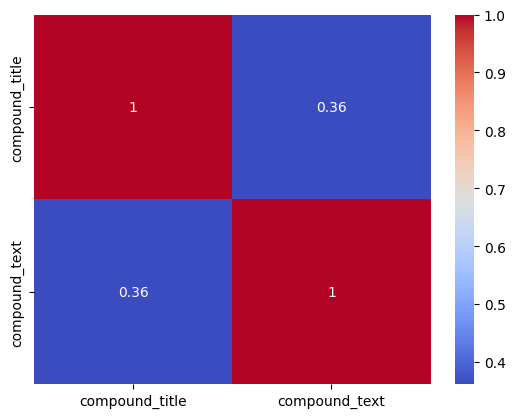

In [64]:
sns.heatmap(
    dfCopy[["compound_title","compound_text"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.show()
#relación debil entre titulo y texto, los titulos no son claros

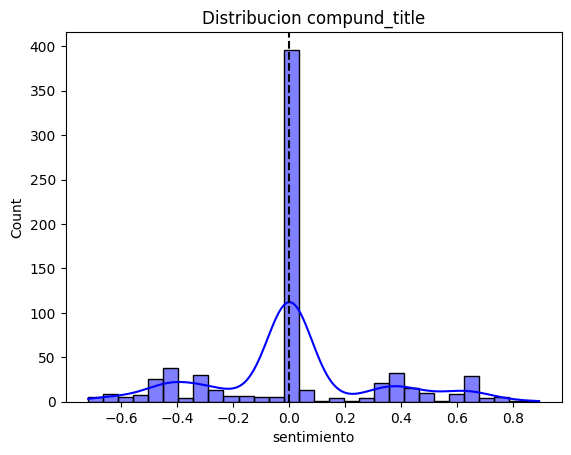

In [65]:
sns.histplot(
    dfCopy["compound_title"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compund_title")
plt.xlabel("sentimiento")
plt.show()

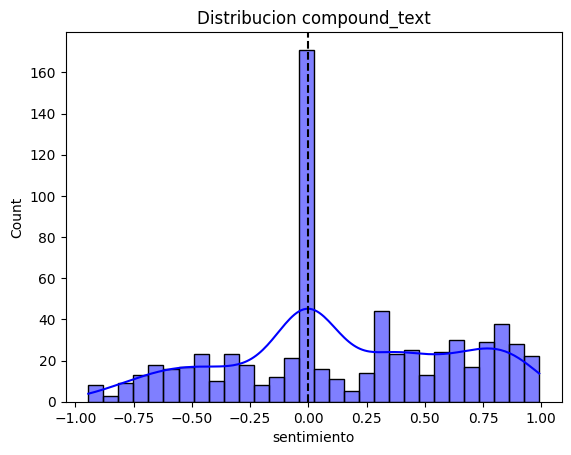

In [66]:
sns.histplot(
    dfCopy["compound_text"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compound_text")
plt.xlabel("sentimiento")
plt.show()

In [67]:
dfCopy["compound_avg"] = dfCopy[["compound_title","compound_text"]].mean(axis=1)

In [68]:
# EL SCORE Y LA OPINION ES MODERADAMENTE CORRELACIONADA
compXscore = dfCopy["score"].corr(dfCopy["compound_avg"])
print("Correlacion entre score y compound_avg", compXscore)

Correlacion entre score y compound_avg 0.5348179790120552


In [69]:
dfCopy["title_length"] = dfCopy["title"].astype(str).str.len()
dfCopy["text_length"] = dfCopy["text"].astype(str).str.len()

In [70]:
dfCopy.columns

Index(['id', 'dateCompleta', 'date', 'year', 'month', 'day', 'time', 'country',
       'userName', 'appId', 'version', 'score', 'title', 'text',
       'idioma_title', 'idioma_texto', 'scoreCat', 'text_sentimentScore',
       'title_sentimentScore', 'neg_text', 'neu_text', 'pos_text',
       'compound_text', 'sentiment_text', 'neg_title', 'neu_title',
       'pos_title', 'compound_title', 'sentiment_title', 'compound_avg',
       'title_length', 'text_length'],
      dtype='object')

### Variables altamnete vacias

In [71]:
dfCopy[(dfCopy['title_length']==0) | (dfCopy['text_length']==0)].shape[0]

0

In [72]:
dfCopy.isnull().mean()

id                      0.0
dateCompleta            0.0
date                    0.0
year                    0.0
month                   0.0
day                     0.0
time                    0.0
country                 0.0
userName                0.0
appId                   0.0
version                 0.0
score                   0.0
title                   0.0
text                    0.0
idioma_title            0.0
idioma_texto            0.0
scoreCat                0.0
text_sentimentScore     0.0
title_sentimentScore    0.0
neg_text                0.0
neu_text                0.0
pos_text                0.0
compound_text           0.0
sentiment_text          0.0
neg_title               0.0
neu_title               0.0
pos_title               0.0
compound_title          0.0
sentiment_title         0.0
compound_avg            0.0
title_length            0.0
text_length             0.0
dtype: float64

In [73]:
ls_missing = [x for x, y in dfCopy.isna().mean().items() if y > 0.3]
ls_missing

[]

### Variables uniarias

In [74]:
df_regresion = dfCopy.drop(columns=['text_sentimentScore', 'title_sentimentScore', 'idioma_title', 'idioma_texto'])

In [75]:
df_regresion.nunique()

id                 500
dateCompleta       327
date               500
year                 6
month               12
day                 31
time               498
country              4
userName           500
appId                1
version            111
score                5
title              458
text               499
scoreCat             2
neg_text           159
neu_text           256
pos_text           222
compound_text      249
sentiment_text       3
neg_title           75
neu_title          120
pos_title           77
compound_title      78
sentiment_title      3
compound_avg       327
title_length        65
text_length        249
dtype: int64

### Eliminar variables que no aportan al modelo

In [76]:
# La unica variable unira es 'appId' y 'scoreCat' es un calculo que utiliza la variables a predecir 'score'
df_regresion = df_regresion.drop(columns=['appId', 'scoreCat', 'id', 'dateCompleta', 'date','userName', 'title', 'text', 'time'])

### Crear variables dummys

In [77]:
df_regresion.columns

Index(['year', 'month', 'day', 'country', 'version', 'score', 'neg_text',
       'neu_text', 'pos_text', 'compound_text', 'sentiment_text', 'neg_title',
       'neu_title', 'pos_title', 'compound_title', 'sentiment_title',
       'compound_avg', 'title_length', 'text_length'],
      dtype='object')

In [78]:
ls_disc = ['country', 'version', 'year', 'sentiment_text', 'sentiment_title']

In [79]:
df_regresion = normalize(df_regresion, [x for x in ls_disc])

In [80]:
freq_discrete(df_regresion, ls_disc)

Feature: country


Absolute frequency Relative frequency Accumulated frequency  \
country                                                               
LK                     316             44.57%                   316   
US                     207             29.20%                   523   
CA                     128             18.05%                   651   
AU                      58              8.18%                   709   

        Accumulated %  
country                
LK             44.57%  
US             73.77%  
CA             91.82%  
AU            100.00%

Feature: version


Absolute frequency Relative frequency Accumulated frequency  \
version                                                                
Others                  622             87.73%                   622   
23.25.86                 50              7.05%                   672   
23.23.82                 37              5.22%                   709   

         Accumulated %  
version                 
Others          87.73%  
23.25.86        94.78%  
23.23.82       100.00%

Feature: year


Absolute frequency Relative frequency Accumulated frequency  \
year                                                                 
2023                  357             50.35%                   357   
2024                  108             15.23%                   465   
2021                   88             12.41%                   553   
2022                   76             10.72%                   629   
2020                   50              7.05%                   679   
Others                 30              4.23%                   709   

       Accumulated %  
year                  
2023          50.35%  
2024          65.59%  
2021          78.00%  
2022          88.72%  
2020          95.77%  
Others       100.00%

Feature: sentiment_text


Absolute frequency Relative frequency Accumulated frequency  \
sentiment_text                                                               
positive                      336             47.39%                   336   
negative                      198             27.93%                   534   
neutral                       175             24.68%                   709   

               Accumulated %  
sentiment_text                
positive              47.39%  
negative              75.32%  
neutral              100.00%

Feature: sentiment_title


Absolute frequency Relative frequency Accumulated frequency  \
sentiment_title                                                               
neutral                        396             55.85%                   396   
negative                       162             22.85%                   558   
positive                       151             21.30%                   709   

                Accumulated %  
sentiment_title                
neutral                55.85%  
negative               78.70%  
positive              100.00%

In [81]:
df_dummies = pd.get_dummies(df_regresion[ls_disc], drop_first=True)

In [82]:
df_regresion = df_regresion.drop(columns=ls_disc).join(df_dummies)

### Separacion de sets

In [83]:
X_regresion = df_regresion[[x for x in df_regresion.columns if x!='score']]
y_regresion = df_regresion['score']

### MULTICOLINEALIDAD

In [84]:
X_regresion.info()

<class 'pandas.core.frame.DataFrame'>
Index: 709 entries, 0 to 1452
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   month                     709 non-null    int32  
 1   day                       709 non-null    int32  
 2   neg_text                  709 non-null    float64
 3   neu_text                  709 non-null    float64
 4   pos_text                  709 non-null    float64
 5   compound_text             709 non-null    float64
 6   neg_title                 709 non-null    float64
 7   neu_title                 709 non-null    float64
 8   pos_title                 709 non-null    float64
 9   compound_title            709 non-null    float64
 10  compound_avg              709 non-null    float64
 11  title_length              709 non-null    int64  
 12  text_length               709 non-null    int64  
 13  country_CA                709 non-null    bool   
 14  country_LK    

13


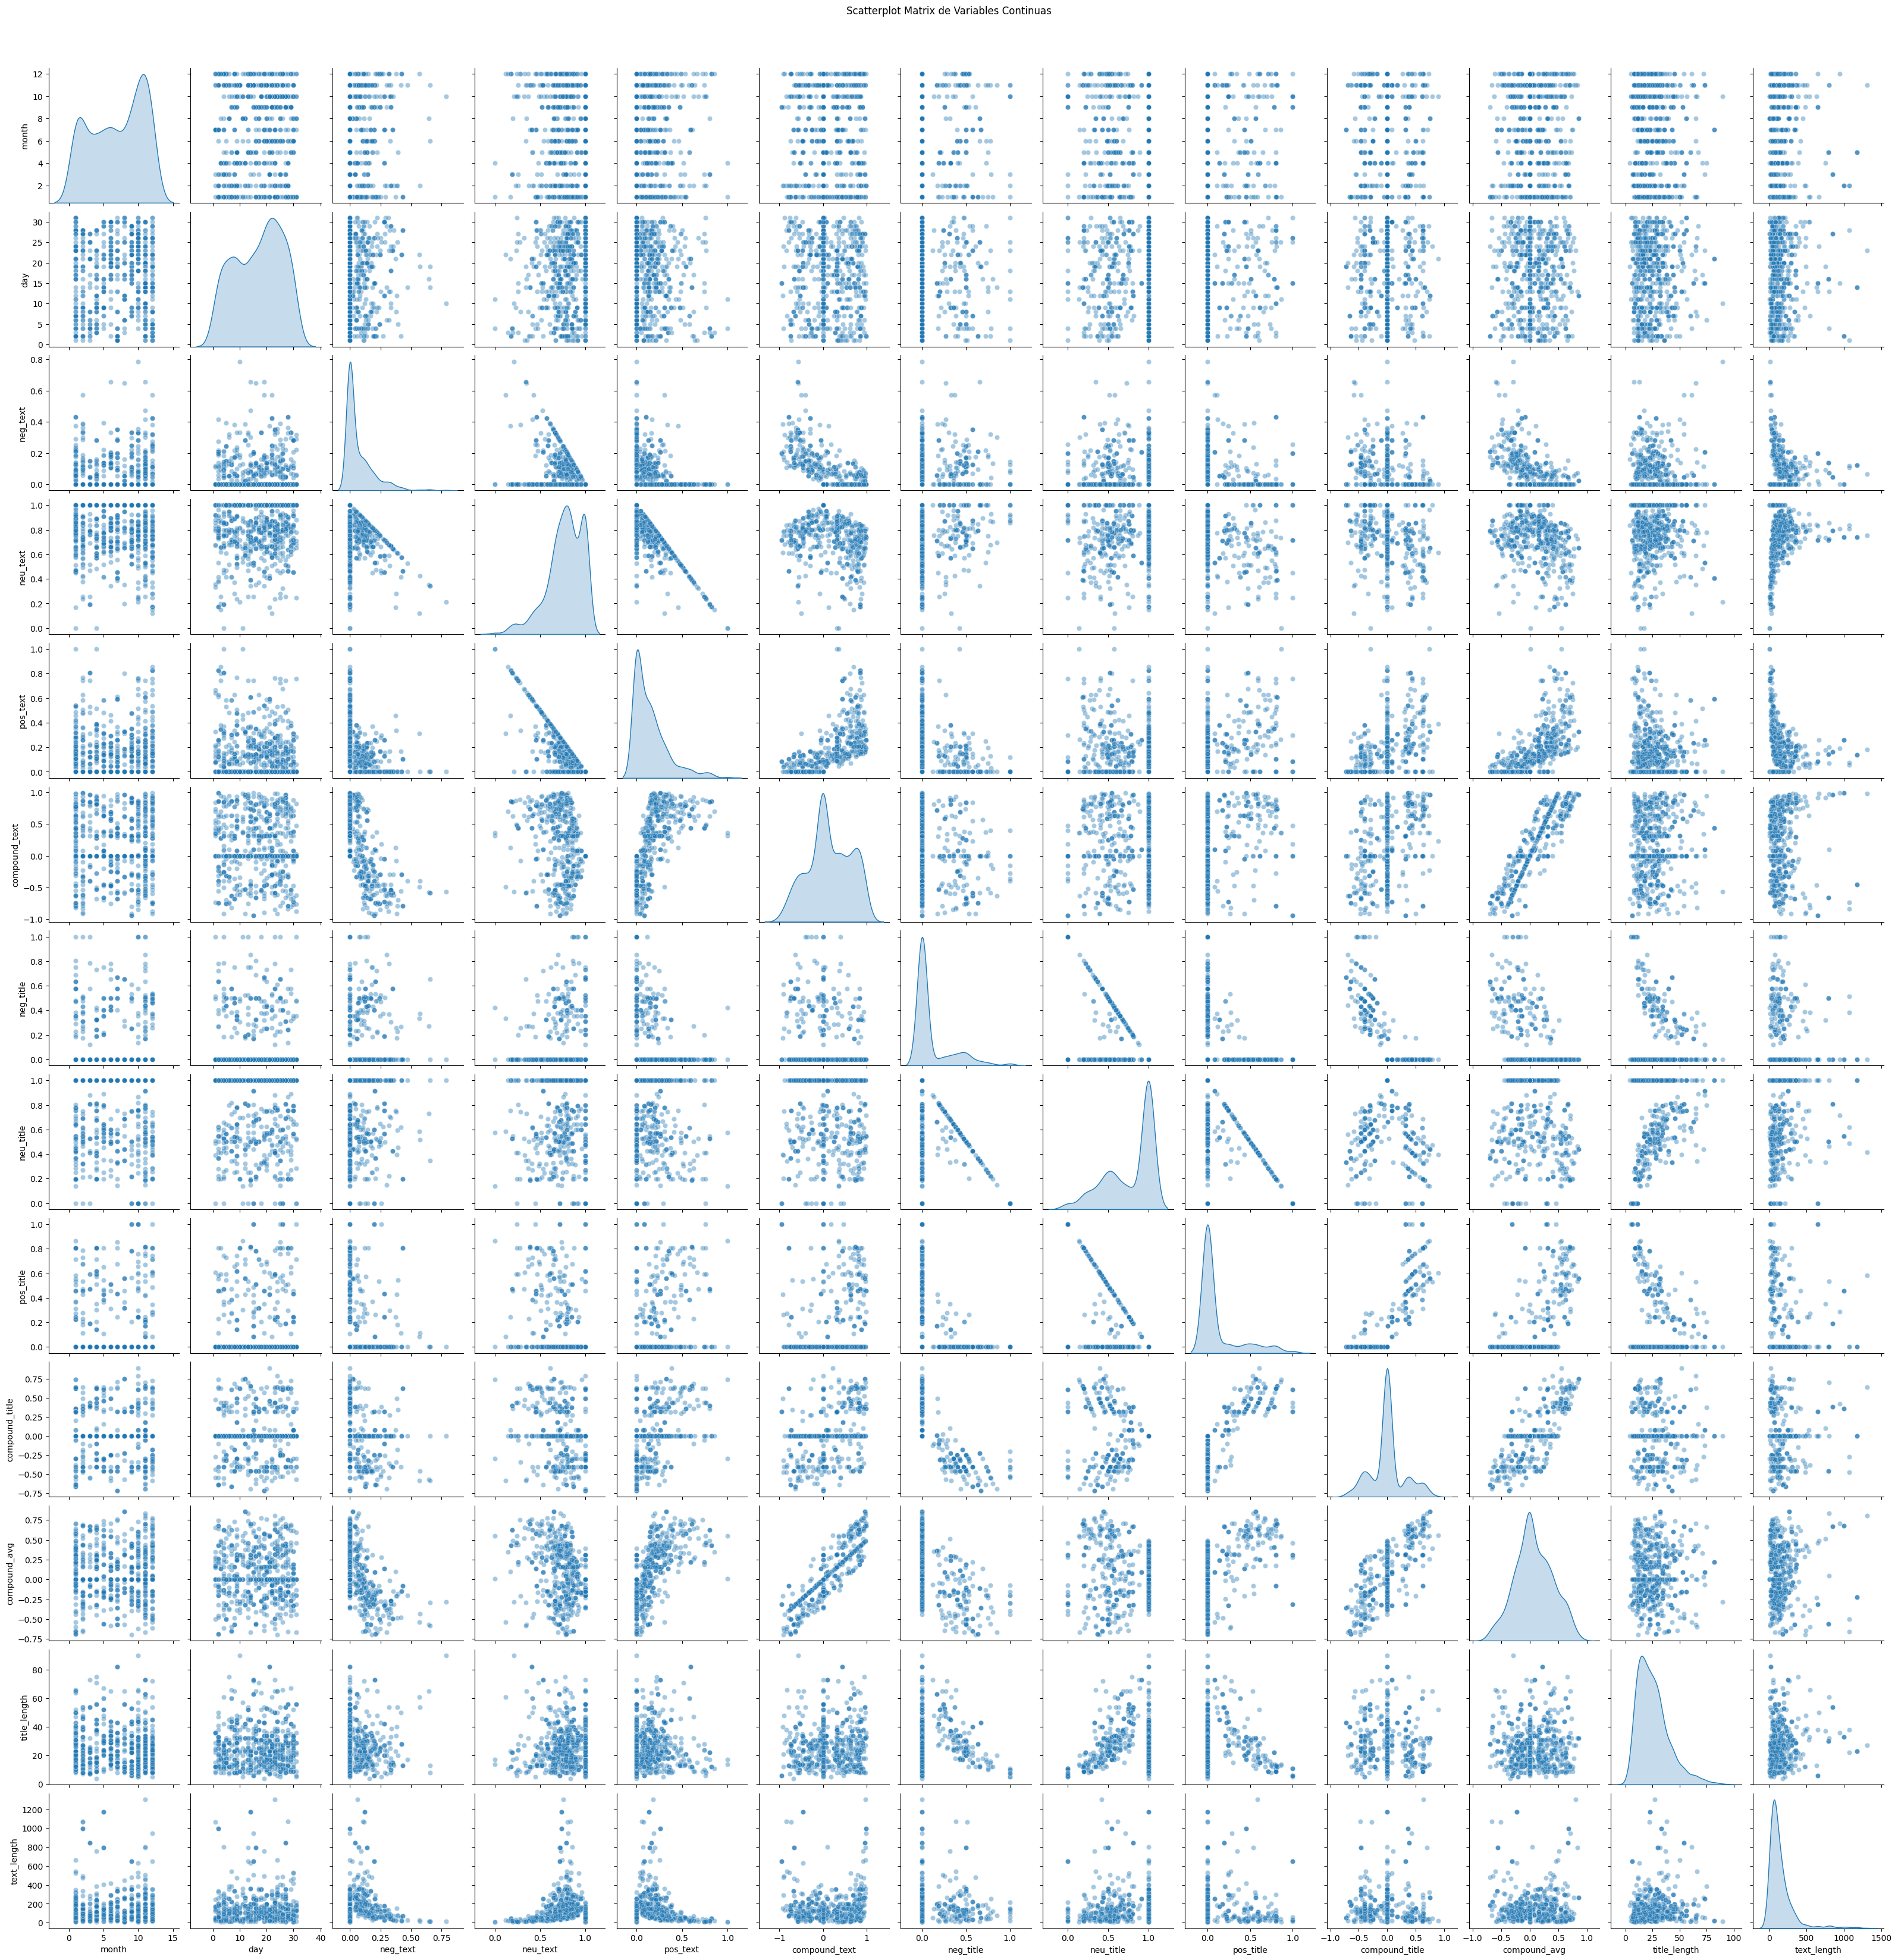

In [85]:
# Filtrar solo esas columnas, que son float64
cols_float = X_regresion.select_dtypes(include=['float64', 'int64', 'int32']).columns
data_float = X_regresion[cols_float]
print(len(cols_float))
# Crear matriz de scatterplots
sns.pairplot(data_float, diag_kind='kde', plot_kws={'alpha':0.4})
plt.suptitle("Scatterplot Matrix de Variables Continuas", y=1.02)
plt.show()

In [86]:
vc = VarClusHi(data_float, maxeigval2=1.0)
vc.varclus()

# Resultados de R^2
print("Tabla de R^2 por variable")
vc.rsquare

Tabla de R^2 por variable


Cluster        Variable    RS_Own     RS_NC  RS_Ratio
0         0        neg_text  0.616946  0.053868  0.404863
1         0   compound_text  0.903700  0.215542  0.122759
2         0    compound_avg  0.871059  0.425304  0.224364
3         1        neu_text  0.911296  0.111192  0.099801
4         1        pos_text  0.911296  0.335826  0.133555
5         2       neu_title  0.839668  0.064152  0.171323
6         2       pos_title  0.839668  0.272868  0.220500
7         3       neg_title  0.846699  0.117886  0.173788
8         3  compound_title  0.846699  0.249539  0.204276
9         4    title_length  0.531251  0.014824  0.475802
10        4           month  0.531251  0.005564  0.471372
11        5             day  0.510823  0.009923  0.494080
12        5     text_length  0.510823  0.018834  0.498567

Las variables ´text_length´, ´title_length´, no aportan nueva información.
Las variables que si aportan informacion son: ´compound_text´ (Muy importante, predice bien),
´compound_avg´ (Importante), ´neg_text´ (Aporta información), ´compound_title´, ´neg_title´, ´pos_text´, son informativas. 
´day´ es relevante mientras que ´month no lo es´.

Las variables optimas de cada cluster son: ´compound_text´, ´neu_text´, ´neu_title´, ´neg_title´

In [87]:
data_float.columns

Index(['month', 'day', 'neg_text', 'neu_text', 'pos_text', 'compound_text',
       'neg_title', 'neu_title', 'pos_title', 'compound_title', 'compound_avg',
       'title_length', 'text_length'],
      dtype='object')

In [88]:
# Calcular matriz de correlación
data_sin_multicolinealidad = data_float[['pos_text', 'neg_text', 'compound_text', 'pos_title', 'compound_title', 'day']]
# data_sin_multicolinealidad = data_float[['neg_text', 'neu_text', 'compound_text', 'neg_title', 'neu_title', 'compound_title', 'day']]
# data_sin_multicolinealidad = data_float.copy()
corr_matrix = data_sin_multicolinealidad.corr(method='pearson')

# Identificar pares de variables altamente correlacionadas (|corr| > 0.85)
redundant_pairs = []
for i in range(len(data_sin_multicolinealidad.columns)):
    for j in range(i+1, len(data_sin_multicolinealidad.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > .7:
            redundant_pairs.append((data_sin_multicolinealidad.columns[i], data_sin_multicolinealidad.columns[j], corr_value))
# Crear DataFrame con resultados
redundant_df = pd.DataFrame(redundant_pairs, 
                            columns=['Variable_1','Variable_2','Correlación'])

# Mostrar las variables candidatas a reducción
print("Variables que tienen correlacion alta con otras:")
print(redundant_df.sort_values(by='Correlación', ascending=False))

Variables que tienen correlacion alta con otras:
  Variable_1      Variable_2  Correlación
0  pos_title  compound_title     0.750695


In [89]:
# vif<5 sin multicolinealidad
for i, col in enumerate(data_sin_multicolinealidad.columns):
    vif = variance_inflation_factor(data_sin_multicolinealidad.values, i)
    print(f"{col}: {vif}")

pos_text: 3.045723017502892
neg_text: 2.2392313747560135
compound_text: 2.916299422785616
pos_title: 3.0341117132029813
compound_title: 2.405575557543318
day: 1.9172870028234288


Las variables que no estan correlacionadas entre si mayores a .5 son: 'neu_text', 'compound_text', 'neu_title', 'compound_title', 'day'

### Seleccion de variables

In [90]:
X_regresion = X_regresion.drop(columns=['month', 'neu_text',
       'neg_title', 'neu_title', 'compound_avg',
       'title_length', 'text_length', 'sentiment_text_positive', 'sentiment_title_positive'])

In [91]:
kb = SelectKBest(k="all", score_func=f_regression)

In [92]:
kb.fit(X_regresion, y_regresion)

SelectKBest(k='all', score_func=<function f_regression at 0x1192f5170>)

In [93]:
X_regresion.info()

<class 'pandas.core.frame.DataFrame'>
Index: 709 entries, 0 to 1452
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      709 non-null    int32  
 1   neg_text                 709 non-null    float64
 2   pos_text                 709 non-null    float64
 3   compound_text            709 non-null    float64
 4   pos_title                709 non-null    float64
 5   compound_title           709 non-null    float64
 6   country_CA               709 non-null    bool   
 7   country_LK               709 non-null    bool   
 8   country_US               709 non-null    bool   
 9   version_23.25.86         709 non-null    bool   
 10  version_Others           709 non-null    bool   
 11  year_2021                709 non-null    bool   
 12  year_2022                709 non-null    bool   
 13  year_2023                709 non-null    bool   
 14  year_2024                709 n

In [94]:
df_scores = pd.DataFrame(data=zip(X_regresion.columns, kb.scores_), columns=["feature", "score"]).set_index("feature").sort_values(by="score", ascending=False)

In [95]:
fig = px.bar(df_scores.reset_index().rename(columns={"index": "feature"}), x="feature", y="score", title="Feature scores")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [96]:
# Calcular importancia relativa acumulada
df_scores['importancia_relativa'] = df_scores['score'] / df_scores['score'].sum()
df_scores['importancia_acumulada'] = df_scores['importancia_relativa'].cumsum()

# Tomar las características que sumen hasta el 80% de importancia
threshold = .94
ls_best = df_scores[df_scores['importancia_acumulada'] <= threshold].index.tolist()

In [97]:
len(ls_best)

5

In [98]:
ls_best

['compound_text', 'pos_text', 'compound_title', 'neg_text', 'pos_title']

In [99]:
df_regresion[ls_best]

compound_text  pos_text  compound_title  neg_text  pos_title
0           -0.6249     0.000          0.0000     0.362      0.000
3            0.9786     0.257          0.0000     0.000      0.000
4            0.3612     0.185         -0.3252     0.000      0.000
5            0.8858     0.722          0.6249     0.000      0.804
6            0.0000     0.000          0.0000     0.000      0.000
...             ...       ...             ...       ...        ...
1443         0.0000     0.000          0.0000     0.000      0.000
1446         0.0000     0.000          0.0000     0.000      0.000
1447         0.2263     0.388          0.8920     0.000      0.603
1449         0.6597     0.329          0.4215     0.000      0.483
1452         0.0108     0.083          0.0000     0.082      0.000

[709 rows x 5 columns]

# CLASIFICACION

## MODELO VADER

CON 3 VARIABLES DERIVADAS DE VADER

In [100]:
# Variable categorica a estimar
# Tomando en cuenta compound avg y score construimos la variable
dfCopy["calidadNum"] = ((dfCopy["compound_avg"] > 0.05) & (dfCopy["score"] >= 3)).astype(int)

In [101]:
X = dfCopy[["compound_title", "compound_text", "compound_avg"]]

In [102]:
y = dfCopy["calidadNum"]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
model = LogisticRegression(random_state=42, max_iter=1000)

In [105]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [106]:
y_pred = model.predict(X_test)

In [107]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8943661971830986


In [108]:
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[88  4]
 [11 39]]


In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        92
           1       0.91      0.78      0.84        50

    accuracy                           0.89       142
   macro avg       0.90      0.87      0.88       142
weighted avg       0.90      0.89      0.89       142



In [110]:
for feature, coef in zip(X.columns, model.coef_[0]):
  print(f"{feature}: {coef:.4f}")

compound_title: 2.7460
compound_text: 3.3492
compound_avg: 3.0476


## MODELO BoW

In [111]:
stop_words = set(stopwords.words('english'))

In [112]:
dfCopy["text_clean"] = dfCopy["text"].astype(str).apply(
    lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words])
)

In [113]:
vectorizer = CountVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=5,
    max_df=0.7
)
X_bow=vectorizer.fit_transform(dfCopy["text_clean"]) 

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, dfCopy["calidadNum"], test_size=0.2, random_state=42
)

In [115]:
model = LogisticRegression(random_state=42, max_iter=1000)

In [116]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [117]:
y_pred = model.predict(X_test)

In [118]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8802816901408451


In [119]:
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[88  4]
 [13 37]]


In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        92
           1       0.90      0.74      0.81        50

    accuracy                           0.88       142
   macro avg       0.89      0.85      0.86       142
weighted avg       0.88      0.88      0.88       142



In [121]:
for feature, coef in zip(X.columns, model.coef_[0]):
  print(f"{feature}: {coef:.4f}")

compound_title: -0.7431
compound_text: -0.2111
compound_avg: -0.5558


In [122]:
words = vectorizer.get_feature_names_out()
coefs = model.coef_[0]
importance = pd.DataFrame({
    "word":words,
    "coef":coefs,
}).sort_values(by="coef",ascending=False)

In [123]:
print("Top 10 positivas")
print(importance.head(10))

Top 10 positivas
          word      coef
330      thank  2.086351
131      great  1.809086
128       good  1.513520
119     friend  1.413728
35        best  1.406774
331     thanks  1.386512
289  secondary  1.223036
15         add  1.127292
143    helpful  1.050806
102       easy  1.042475


In [124]:
print("Top 10 negativas")
print(importance.tail(10))

Top 10 negativas
         word      coef
251   problem -0.921193
318  suddenly -0.934846
321   support -0.959701
19   annoying -1.011793
349   updated -1.034942
77   crashing -1.074502
124   getting -1.079549
88    deleted -1.080793
220      open -1.131035
172    latest -1.315613


## MODELO COMBINADO

In [125]:
# EN ESTE MODELO SE USARON LAS CARACTERISTICAS DERIVADAS DE VADER Y LAS PALABRAS
X_vader = dfCopy[["compound_title","compound_text","compound_avg"]]

In [126]:
X_vader_array = X_vader.values

In [127]:
X_combined = hstack([X_bow, X_vader_array])

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, dfCopy["calidadNum"], test_size=0.2, random_state=42
)

In [129]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [130]:
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.9366197183098591
Confusion Matrix: 
 [[90  2]
 [ 7 43]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        92
           1       0.96      0.86      0.91        50

    accuracy                           0.94       142
   macro avg       0.94      0.92      0.93       142
weighted avg       0.94      0.94      0.94       142



### ESCALAMIENTO

No es necesario aplicar escalamiento, ya que las variables contienen valores muy pequeños

# DIVIDIR EN CONJUTO DE TRAIN Y TEST

In [131]:
X_regresion[ls_best].describe()

compound_text    pos_text  compound_title    neg_text   pos_title
count     709.000000  709.000000      709.000000  709.000000  709.000000
mean        0.145094    0.152772        0.006314    0.071454    0.118382
std         0.485671    0.188108        0.292529    0.114584    0.243328
min        -0.944000    0.000000       -0.718400    0.000000    0.000000
25%        -0.121700    0.000000        0.000000    0.000000    0.000000
50%         0.000000    0.100000        0.000000    0.000000    0.000000
75%         0.560800    0.226000        0.000000    0.116000    0.000000
max         0.991400    1.000000        0.892000    0.787000    1.000000

In [132]:
X_train_regresion, X_test_regresion, y_train_regresion, y_test_regresion = train_test_split(X_regresion[ls_best], y_regresion, test_size=0.3, random_state=42)

In [133]:
pd.DataFrame(y_regresion).describe()

score
count  709.000000
mean     2.957687
std      1.736421
min      1.000000
25%      1.000000
50%      3.000000
75%      5.000000
max      5.000000

# REGRESION

## REGRESION LINEAL

### ENTRENAMIENTO

In [134]:
linreg = LinearRegression()

In [135]:
linreg.fit(X_train_regresion, y_train_regresion)

LinearRegression()

In [136]:
linreg.score(X_train_regresion, y_train_regresion)

0.30998487971523714

### VALIDACION CRUZADA

In [137]:
ls_res = cross_val_score(X=X_train_regresion, y=y_train_regresion, estimator=linreg, cv=10, scoring="r2", n_jobs=-1)

In [138]:
ls_res

array([0.09567992, 0.31070867, 0.40400891, 0.30289769, 0.36999433,
       0.45480978, 0.1765658 , 0.46817025, 0.06298039, 0.28503599])

In [139]:
ls_res.mean(), ls_res.std()

(np.float64(0.2930851737966013), np.float64(0.13453408388026988))

### VALIDACION TEST

In [140]:
linreg.score(X_test_regresion, y_test_regresion)

0.33083591578012816

### PREDICCION DE TEST

In [141]:
y_pred = linreg.predict(X_test_regresion)

### Métricas de performance

#### R²

In [142]:
r2_score(y_true=y_test_regresion, y_pred=y_pred)

0.33083591578012816

#### PEMA

In [143]:
pema = mean_absolute_percentage_error(y_true=y_test_regresion, y_pred=y_pred)

In [144]:
f"{pema:,.2%}"

'64.56%'

#### MAE

In [145]:
mean_absolute_error(y_true=y_test_regresion, y_pred=y_pred)

1.2165379225747168

In [146]:
pd.DataFrame(y_pred).describe()

0
count  213.000000
mean     2.889047
std      0.918234
min     -0.065939
25%      2.363219
50%      2.757089
75%      3.441852
max      5.200656

### Interpretación

In [147]:
linreg.intercept_

np.float64(2.757089240621932)

In [148]:
y_train_regresion.mean()

np.float64(2.933467741935484)

In [149]:
df_res = pd.DataFrame(data=zip(X_train_regresion.columns, linreg.coef_), columns=["feature", "weight"])
df_res.sort_values(by="weight")

feature    weight
3        neg_text -2.973295
0   compound_text  0.527655
4       pos_title  0.699806
2  compound_title  1.034436
1        pos_text  1.371670

In [150]:
y_train_regresion.describe(percentiles=[x/10 for x in range(10)])

count    496.000000
mean       2.933468
std        1.735433
min        1.000000
0%         1.000000
10%        1.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        5.000000
90%        5.000000
max        5.000000
Name: score, dtype: float64

### Predicción final

In [151]:
df_regresion["y_hat"] = linreg.predict(df_regresion[X_train_regresion.columns])

In [152]:
df_regresion[['score', "y_hat"]].sample(10)

score     y_hat
674       5  5.253982
990       3  3.337056
1379      1  1.815858
395       1  1.879321
1033      1  1.580801
224       1  1.480835
50        1  2.341349
633       5  3.966152
344       1  2.757089
943       2  2.757089

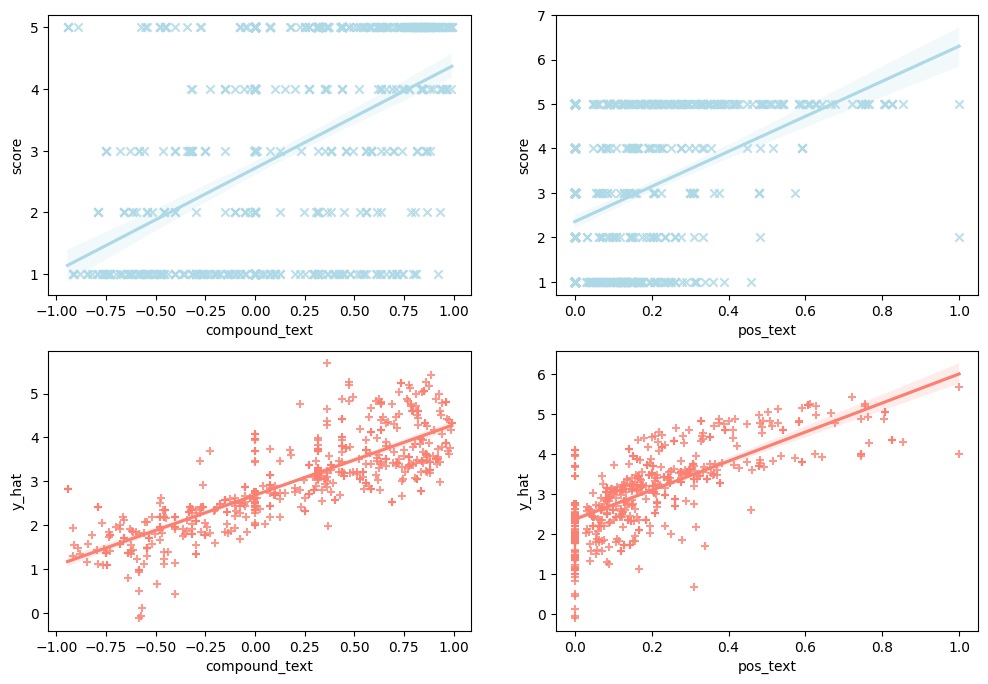

In [153]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[1],y='score', data=df_regresion , marker='x', color='lightblue')
plt.subplot(2,2,2)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[-1],y='score', data=df_regresion , marker='x', color='lightblue')
plt.subplot(2,2,3)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[1],y='y_hat', data=df_regresion , marker='+', color='salmon')
plt.subplot(2,2,4)
sns.regplot(x=list(df_res.sort_values(by="weight")['feature'])[-1],y='y_hat', data=df_regresion , marker='+', color='salmon')


plt.show()

## REGRESION LARS

### ENTRENAMIENTO

### VALIDCACION CRUZADA

## Escalamiento de datos

#### Min Max Scaler

In [154]:
# Separar variables continuas de booleanas
continuous_cols = ['compound_text', 'pos_text', 'neg_text', 'compound_title', 'pos_title', 'neg_text']
boolean_cols = [col for col in X_train_regresion.columns if col not in continuous_cols]

In [155]:
mm = MinMaxScaler()
mm_y = MinMaxScaler()

In [156]:
Xm = X_train_regresion.copy()
Xm[continuous_cols] = mm.fit_transform(X_train_regresion[continuous_cols])
ym = mm_y.fit_transform(y_train_regresion.values.reshape(-1, 1))

#### Standard Scaler

In [157]:
ss = StandardScaler()
ss_y = StandardScaler()

In [158]:
Xs = X_train_regresion.copy()
Xs[continuous_cols] = ss.fit_transform(X_train_regresion[continuous_cols])
ys = ss_y.fit_transform(y_train_regresion.values.reshape(-1, 1))

#### Robust Scaler

In [159]:
rs = RobustScaler()
rs_y = RobustScaler()

In [160]:
Xr = X_train_regresion.copy()
Xr[continuous_cols] = rs.fit_transform(X_train_regresion[continuous_cols])
yr = rs_y.fit_transform(y_train_regresion.values.reshape(-1, 1))

## REGRESION CRESTA (RIDGE)

### ENTRENAMIENTO

In [161]:
ridgereg = Ridge(alpha=100, random_state=42)

In [162]:
ridgereg.fit(X_train_regresion, y_train_regresion)

Ridge(alpha=100, random_state=42)

### VALIDACION CRUZADA

In [163]:
ls_res = cross_val_score(estimator = ridgereg, X=X_train_regresion, y=y_train_regresion, cv=4, n_jobs=-1, scoring="r2")

In [164]:
ls_res

array([0.18725219, 0.23952483, 0.22433616, 0.20134335])

In [165]:
np.mean(ls_res), np.std(ls_res)

(np.float64(0.21311413346557986), np.float64(0.02019189388037504))

### BUSQUEDA DE LA MEJOR $\alpha$ ($\lambda$)

In [166]:
df_res = pd.DataFrame()
for i in range(0, 1_000, 5):
    ridgereg = Ridge(alpha=i)
    ridgereg.fit(X_train_regresion, y_train_regresion)
    ls_res = cross_val_score(estimator = ridgereg, X=X_train_regresion, y=y_train_regresion, cv=4, n_jobs=-1, scoring="r2")
    df_res.loc[i, "r2_mean"] = np.mean(ls_res)
    df_res.loc[i, "r2_std"] = np.std(ls_res)
    print(i, "{:,.2%}".format(np.mean(ls_res)), "{:,.2f}".format(np.std(ls_res)))

0 29.37% 0.05
5 28.99% 0.04
10 28.54% 0.04
15 28.15% 0.04
20 27.76% 0.04
25 27.36% 0.03
30 26.94% 0.03
35 26.52% 0.03
40 26.09% 0.03
45 25.66% 0.03
50 25.24% 0.03
55 24.81% 0.03
60 24.39% 0.03
65 23.98% 0.03
70 23.57% 0.02
75 23.17% 0.02
80 22.78% 0.02
85 22.40% 0.02
90 22.03% 0.02
95 21.67% 0.02
100 21.31% 0.02
105 20.97% 0.02
110 20.63% 0.02
115 20.30% 0.02
120 19.98% 0.02
125 19.67% 0.02
130 19.36% 0.02
135 19.07% 0.02
140 18.78% 0.02
145 18.50% 0.02
150 18.23% 0.02
155 17.96% 0.02
160 17.70% 0.02
165 17.45% 0.01
170 17.20% 0.01
175 16.96% 0.01
180 16.73% 0.01
185 16.50% 0.01
190 16.28% 0.01
195 16.06% 0.01
200 15.85% 0.01
205 15.64% 0.01
210 15.44% 0.01
215 15.25% 0.01
220 15.05% 0.01
225 14.87% 0.01
230 14.68% 0.01
235 14.50% 0.01
240 14.33% 0.01
245 14.16% 0.01
250 13.99% 0.01
255 13.83% 0.01
260 13.67% 0.01
265 13.51% 0.01
270 13.36% 0.01
275 13.21% 0.01
280 13.06% 0.01
285 12.92% 0.01
290 12.78% 0.01
295 12.64% 0.01
300 12.51% 0.01
305 12.37% 0.01
310 12.24% 0.01
315 12.12% 0.0

In [167]:
fig = px.line(df_res)
fig.show()

In [168]:
df_res.sort_values(by="r2_mean")

r2_mean    r2_std
995  0.049322  0.004127
990  0.049543  0.004140
985  0.049766  0.004153
980  0.049992  0.004166
975  0.050219  0.004179
..        ...       ...
20   0.277597  0.035681
15   0.281507  0.037393
10   0.285414  0.039366
5    0.289910  0.042076
0    0.293689  0.052797

[200 rows x 2 columns]

In [169]:
ridgereg = Ridge(alpha=0.001, random_state=42)

In [170]:
ridgereg.fit(X_train_regresion, y_train_regresion)

Ridge(alpha=0.001, random_state=42)

In [171]:
ridgereg.intercept_

np.float64(2.7570435920764123)

In [172]:
pd.DataFrame(zip(X_train_regresion.columns, ridgereg.coef_)).sort_values(by=1)

0         1
3        neg_text -2.972478
0   compound_text  0.527827
4       pos_title  0.699792
2  compound_title  1.034454
1        pos_text  1.371422

In [173]:
dc_scores = dict()
dc_scores.update({str(ridgereg).split("(")[0] + "_ns": {"model": ridgereg, "score": np.mean(ls_res)}})

In [174]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [175]:
ridge = Ridge(random_state=42)

In [176]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [177]:
np.prod(list(map(len, param_grid.values())))

np.int64(2289)

In [178]:
search = RandomizedSearchCV(ridge, param_grid, cv=4, random_state=42, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1, n_iter=100)
search.fit(Xm, ym.ravel())

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, error_score=-1000, estimator=Ridge(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 1e-07, 0.01]},
                   random_state=42, scoring='r2', verbose=1)

In [179]:
search.best_estimator_

Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01)

In [180]:
summary = pd.DataFrame(search.cv_results_)

In [181]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_tol  \
31       0.000935      0.000718         0.000420        0.000178       0.01   
83       0.001059      0.000208         0.000522        0.000252       0.01   

   param_solver  param_alpha  \
31     cholesky          2.0   
83    sparse_cg          3.0   

                                              params  split0_test_score  \
31   {'tol': 0.01, 'solver': 'cholesky', 'alpha': 2}           0.232147   
83  {'tol': 0.01, 'solver': 'sparse_cg', 'alpha': 3}           0.232905   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
31           0.355065           0.331766           0.265012         0.295997   
83           0.351194           0.331643           0.267768         0.295878   

    std_test_score  rank_test_score  
31        0.049511                1  
83        0.047683                2

In [182]:
summary.to_csv(r'./data_final/summary_ridge_m.csv', encoding='utf-8-sig', index=False)

In [183]:
search.best_estimator_

Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01)

In [184]:
dc_scores[str(ridge).split("(")[0] + "_m"] = {"model": search.best_estimator_, "score": search.best_score_}

In [185]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [186]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [187]:
np.prod(list(map(len, param_grid.values())))

np.int64(2289)

In [188]:
search = RandomizedSearchCV(ridge, param_grid, cv=4, random_state=42, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1, n_iter=100)
search.fit(Xs, ys.ravel())

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, error_score=-1000, estimator=Ridge(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 1e-07, 0.01]},
                   random_state=42, scoring='r2', verbose=1)

In [189]:
search.best_estimator_

Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01)

In [190]:
summary = pd.DataFrame(search.cv_results_)

In [191]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_tol  \
98       0.001047      0.000339         0.000698        0.000334       0.01   
89       0.001016      0.000385         0.000477        0.000101       0.01   

   param_solver  param_alpha  \
98    sparse_cg         66.0   
89         lsqr         53.0   

                                               params  split0_test_score  \
98  {'tol': 0.01, 'solver': 'sparse_cg', 'alpha': 66}           0.238118   
89       {'tol': 0.01, 'solver': 'lsqr', 'alpha': 53}           0.237688   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
98           0.355433           0.330903           0.265515         0.297492   
89           0.356699           0.331151           0.264083         0.297405   

    std_test_score  rank_test_score  
98        0.047490                1  
89        0.048298                2

In [192]:
summary.to_csv(r'./data_final/summary_ridge_s.csv', encoding='utf-8-sig', index=False)

In [193]:
search.best_estimator_

Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01)

In [194]:
dc_scores[str(ridge).split("(")[0] + "_s"] = {"model": search.best_estimator_, "score": search.best_score_}

In [195]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [196]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [197]:
np.prod(list(map(len, param_grid.values())))

np.int64(2289)

In [198]:
search = RandomizedSearchCV(ridge, param_grid, cv=4, random_state=42, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1, n_iter=100)
search.fit(Xr, yr.ravel())

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, error_score=-1000, estimator=Ridge(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 1e-07, 0.01]},
                   random_state=42, scoring='r2', verbose=1)

In [199]:
search.best_estimator_

Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07)

In [200]:
summary = pd.DataFrame(search.cv_results_)

In [201]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
61       0.000965      0.000132         0.000408        0.000106   
3        0.001291      0.000318         0.000583        0.000282   

       param_tol param_solver  param_alpha  \
61  1.000000e-07          sag          5.0   
3   1.000000e-02         auto          3.0   

                                         params  split0_test_score  \
61  {'tol': 1e-07, 'solver': 'sag', 'alpha': 5}           0.221837   
3   {'tol': 0.01, 'solver': 'auto', 'alpha': 3}           0.223621   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
61           0.361232            0.33562           0.258351         0.294260   
3            0.361157            0.33338           0.258879         0.294259   

    std_test_score  rank_test_score  
61        0.056415                1  
3         0.055334                2

In [202]:
summary.to_csv(r'./data_final/summary_ridge_r.csv', encoding='utf-8-sig', index=False)

In [203]:
search.best_estimator_

Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07)

In [204]:
dc_scores[str(ridge).split("(")[0] + "_r"] = {"model": search.best_estimator_, "score": search.best_score_}

In [205]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)}}

## REGRESION LASSO

### ENTRENAMIENTO

In [206]:
lassreg = Lasso(alpha=0.5, random_state=42)

In [207]:
lassreg.fit(X_train_regresion, y_train_regresion)

Lasso(alpha=0.5, random_state=42)

### VALIDICACION CRUZADA

In [208]:
ls_res = cross_val_score(estimator = lassreg, X=X_train_regresion, y=y_train_regresion, cv=4, n_jobs=-1, scoring="r2")

In [209]:
ls_res

array([-1.82881398e-03, -2.08737763e-05, -5.49595498e-04, -4.78855854e-03])

In [210]:
np.mean(ls_res), np.std(ls_res)

(np.float64(-0.0017969604479308732), np.float64(0.0018480447073263404))

In [211]:
lassreg.intercept_

np.float64(2.933467741935484)

In [212]:
pd.DataFrame(zip(X_train_regresion.columns, lassreg.coef_)).sort_values(by=1)

0    1
0   compound_text  0.0
1        pos_text  0.0
2  compound_title  0.0
3        neg_text  0.0
4       pos_title  0.0

### BUSQUEDA DE LA MEJOR $\alpha$ ($\lambda$)

In [213]:
df_res = pd.DataFrame()
for i in range(10, 1010, 10):
    lasso = Lasso(alpha=i/100)
    lasso.fit(X_train_regresion, y_train_regresion)
    ls_res = cross_val_score(estimator = lasso, X=X_train_regresion, y=y_train_regresion, cv=4, n_jobs=-1, scoring="r2")
    df_res.loc[i/100, "r2_mean"] = np.mean(ls_res)
    df_res.loc[i/100, "r2_std"] = np.std(ls_res)
    print(i, "{:,.2%}".format(np.mean(ls_res)), "{:,.2f}".format(np.std(ls_res)))

10 23.05% 0.03
20 14.55% 0.01
30 7.67% 0.01
40 0.02% 0.00
50 -0.18% 0.00
60 -0.18% 0.00
70 -0.18% 0.00
80 -0.18% 0.00
90 -0.18% 0.00
100 -0.18% 0.00
110 -0.18% 0.00
120 -0.18% 0.00
130 -0.18% 0.00
140 -0.18% 0.00
150 -0.18% 0.00
160 -0.18% 0.00
170 -0.18% 0.00
180 -0.18% 0.00
190 -0.18% 0.00
200 -0.18% 0.00
210 -0.18% 0.00
220 -0.18% 0.00
230 -0.18% 0.00
240 -0.18% 0.00
250 -0.18% 0.00
260 -0.18% 0.00
270 -0.18% 0.00
280 -0.18% 0.00
290 -0.18% 0.00
300 -0.18% 0.00
310 -0.18% 0.00
320 -0.18% 0.00
330 -0.18% 0.00
340 -0.18% 0.00
350 -0.18% 0.00
360 -0.18% 0.00
370 -0.18% 0.00
380 -0.18% 0.00
390 -0.18% 0.00
400 -0.18% 0.00
410 -0.18% 0.00
420 -0.18% 0.00
430 -0.18% 0.00
440 -0.18% 0.00
450 -0.18% 0.00
460 -0.18% 0.00
470 -0.18% 0.00
480 -0.18% 0.00
490 -0.18% 0.00
500 -0.18% 0.00
510 -0.18% 0.00
520 -0.18% 0.00
530 -0.18% 0.00
540 -0.18% 0.00
550 -0.18% 0.00
560 -0.18% 0.00
570 -0.18% 0.00
580 -0.18% 0.00
590 -0.18% 0.00
600 -0.18% 0.00
610 -0.18% 0.00
620 -0.18% 0.00
630 -0.18% 0.00
640

In [214]:
fig = px.line(df_res)
fig.show()


In [215]:
lasso = Lasso(alpha=0.001, random_state=42)

In [216]:
lasso.fit(X_train_regresion, y_train_regresion)

Lasso(alpha=0.001, random_state=42)

In [217]:
ls_res = cross_val_score(estimator = lasso, X=X_train_regresion, y=y_train_regresion, cv=4, n_jobs=-1, scoring="r2")

In [218]:
np.mean(ls_res), np.std(ls_res)

(np.float64(0.2937935791966979), np.float64(0.05175265528223306))

In [219]:
dc_scores.update({str(lasso).split("(")[0] + "_ns": {"model": lasso, "score": np.mean(ls_res)}})

In [220]:
lasso.coef_

array([ 0.55466607,  1.32092614,  1.03894116, -2.8452265 ,  0.68775852])

In [221]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)},
 'Lasso_ns': {'model': Lasso(alpha=0.001, random_state=42),
  'score': np.float64(0.2937935791966979)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [222]:
lasso = Lasso(random_state=42)

In [223]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "selection": ['cyclic', 'random']
}

In [224]:
np.prod(list(map(len, param_grid.values())))

np.int64(654)

In [225]:
search = GridSearchCV(lasso, param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring="r2", verbose=5)

### ENTRENAMIENTO CON DATOS ESCALADOS

In [226]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [227]:
np.prod(list(map(len, param_grid.values())))

np.int64(2289)

In [228]:
search = RandomizedSearchCV(ridge, param_grid, cv=4, random_state=42, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1, n_iter=100)
search.fit(Xs, ys.ravel())

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, error_score=-1000, estimator=Ridge(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 1e-07, 0.01]},
                   random_state=42, scoring='r2', verbose=1)

In [229]:
search.best_estimator_

Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01)

In [230]:
summary = pd.DataFrame(search.cv_results_)

In [231]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_tol  \
98       0.001392      0.000113         0.000747        0.000188       0.01   
89       0.001239      0.000377         0.000723        0.000338       0.01   

   param_solver  param_alpha  \
98    sparse_cg         66.0   
89         lsqr         53.0   

                                               params  split0_test_score  \
98  {'tol': 0.01, 'solver': 'sparse_cg', 'alpha': 66}           0.238118   
89       {'tol': 0.01, 'solver': 'lsqr', 'alpha': 53}           0.237688   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
98           0.355433           0.330903           0.265515         0.297492   
89           0.356699           0.331151           0.264083         0.297405   

    std_test_score  rank_test_score  
98        0.047490                1  
89        0.048298                2

In [232]:
search.best_estimator_

Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01)

In [233]:
summary.to_csv(r'./data_final/summary_ridge_s.csv', encoding='utf-8-sig', index=False)

In [234]:
dc_scores[str(ridge).split("(")[0] + "_s"] = {"model": search.best_estimator_, "score": search.best_score_}

In [235]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)},
 'Lasso_ns': {'model': Lasso(alpha=0.001, random_state=42),
  'score': np.float64(0.2937935791966979)}}

In [236]:
search.fit(Xm, ym.ravel())

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, error_score=-1000, estimator=Ridge(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 1e-07, 0.01]},
                   random_state=42, scoring='r2', verbose=1)

In [237]:
print("Best score: " + str(search.best_score_))

Best score: 0.29599728304566797


In [238]:
search.best_estimator_

Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01)

In [239]:
summary = pd.DataFrame(search.cv_results_)

In [240]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_tol  \
31       0.000784      0.000347         0.000624        0.000296       0.01   
83       0.001097      0.000497         0.000576        0.000366       0.01   

   param_solver  param_alpha  \
31     cholesky          2.0   
83    sparse_cg          3.0   

                                              params  split0_test_score  \
31   {'tol': 0.01, 'solver': 'cholesky', 'alpha': 2}           0.232147   
83  {'tol': 0.01, 'solver': 'sparse_cg', 'alpha': 3}           0.232905   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
31           0.355065           0.331766           0.265012         0.295997   
83           0.351194           0.331643           0.267768         0.295878   

    std_test_score  rank_test_score  
31        0.049511                1  
83        0.047683                2

In [241]:
summary.to_csv(r'./data_final/summary_lasso_m.csv', encoding='utf-8-sig', index=False)

In [242]:
dc_scores[str(lasso).split("(")[0] + "_m"] = {"model": search.best_estimator_, "score": search.best_score_}

In [243]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)},
 'Lasso_ns': {'model': Lasso(alpha=0.001, random_state=42),
  'score': np.float64(0.2937935791966979)},
 'Lasso_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [244]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "selection": ['cyclic', 'random']
}

In [245]:
np.prod(list(map(len, param_grid.values())))

np.int64(654)

In [246]:
search = GridSearchCV(lasso, param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring="r2", verbose=5)

In [247]:
search.fit(Xs, ys.ravel())

Fitting 4 folds for each of 654 candidates, totalling 2616 fits
[CV 2/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.000 total time=   0.0s
[CV 1/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.002 total time=   0.0s
[CV 3/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.001 total time=   0.0s
[CV 1/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.002 total time=   0.0s
[CV 4/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.005 total time=   0.0s
[CV 2/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.000 total time=   0.0s
[CV 3/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.001 total time=   0.0s
[CV 4/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.005 total time=   0.0s
[CV 1/4] END alpha=1, selection=cyclic, tol=0.01;, score=-0.002 total time=   0.0s
[CV 1/4] END alpha=1, selection=random, tol=1e-05;, score=-0.002 total time=   0.0s
[CV 2/4] END alpha=1, selection=cyclic, tol=0.01;, score=-0.000 total time=   0.0s
[CV 3/4] END a

/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/base.py:1336: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+02, tolerance: 3.770e-03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/

GridSearchCV(cv=4, error_score=-1000, estimator=Lasso(random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...],
                         'selection': ['cyclic', 'random'],
                         'tol': [1e-05, 1e-07, 0.01]},
             scoring='r2', verbose=5)

In [248]:
print("Best score: " + str(search.best_score_))

Best score: 0.29368893872965274


In [249]:
search.best_estimator_

Lasso(alpha=0.0, random_state=42, tol=1e-05)

In [250]:
summary = pd.DataFrame(search.cv_results_)

In [251]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
594       0.006742      0.004882         0.001134        0.000184   
595       0.005158      0.003111         0.000957        0.000272   

     param_alpha param_selection     param_tol  \
594          0.0          cyclic  1.000000e-05   
595          0.0          cyclic  1.000000e-07   

                                                params  split0_test_score  \
594  {'alpha': 0.0, 'selection': 'cyclic', 'tol': 1...           0.227358   
595  {'alpha': 0.0, 'selection': 'cyclic', 'tol': 1...           0.227358   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
594           0.360133           0.327805           0.259459         0.293689   
595           0.360133           0.327805           0.259459         0.293689   

     std_test_score  rank_test_score  
594        0.052797                1  
595        0.052797                1

In [252]:
summary.to_csv(r'./data_final/summary_lasso_s.csv', encoding='utf-8-sig', index=False)

In [253]:
dc_scores[str(lasso).split("(")[0] + "_s"] = {"model": search.best_estimator_, "score": search.best_score_}

In [254]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)},
 'Lasso_ns': {'model': Lasso(alpha=0.001, random_state=42),
  'score': np.float64(0.2937935791966979)},
 'Lasso_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Lasso_s': {'model': Lasso(alpha=0.0, random_state=42, tol=1e-05),
  'score': np.float64(0.29368893872965274)}}

### ENTRENAMIENTO CON DATOS ESCALADOS

In [255]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "selection": ['cyclic', 'random']
}

In [256]:
np.prod(list(map(len, param_grid.values())))

np.int64(654)

In [257]:
search = GridSearchCV(lasso, param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring="r2", verbose=5)

In [258]:
search.fit(Xr, yr.ravel())

Fitting 4 folds for each of 654 candidates, totalling 2616 fits
[CV 1/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.002 total time=   0.0s
[CV 2/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.000 total time=   0.0s
[CV 3/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.001 total time=   0.0s
[CV 4/4] END alpha=1, selection=cyclic, tol=1e-05;, score=-0.005 total time=   0.0s
[CV 2/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.000 total time=   0.0s
[CV 1/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.002 total time=   0.0s
[CV 4/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.005 total time=   0.0s
[CV 1/4] END alpha=1, selection=cyclic, tol=0.01;, score=-0.002 total time=   0.0s
[CV 3/4] END alpha=1, selection=cyclic, tol=1e-07;, score=-0.001 total time=   0.0s
[CV 2/4] END alpha=1, selection=cyclic, tol=0.01;, score=-0.000 total time=   0.0s
[CV 4/4] END alpha=1, selection=cyclic, tol=0.01;, score=-0.005 total time=   0.0s[CV 3/4] END alp

/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/base.py:1336: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/juanmi/Documents/DCD/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+01, tolerance: 7.082e-04
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/

GridSearchCV(cv=4, error_score=-1000, estimator=Lasso(random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...],
                         'selection': ['cyclic', 'random'],
                         'tol': [1e-05, 1e-07, 0.01]},
             scoring='r2', verbose=5)

In [259]:
print("Best score: " + str(search.best_score_))

Best score: 0.2936889387296527


In [260]:
search.best_estimator_

Lasso(alpha=0.0, random_state=42, tol=1e-05)

In [261]:
summary = pd.DataFrame(search.cv_results_)

In [262]:
summary.sort_values(by = "rank_test_score").head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
595       0.003004      0.000253         0.001603        0.000775   
594       0.004072      0.000808         0.001509        0.000715   

     param_alpha param_selection     param_tol  \
595          0.0          cyclic  1.000000e-07   
594          0.0          cyclic  1.000000e-05   

                                                params  split0_test_score  \
595  {'alpha': 0.0, 'selection': 'cyclic', 'tol': 1...           0.227358   
594  {'alpha': 0.0, 'selection': 'cyclic', 'tol': 1...           0.227358   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
595           0.360133           0.327805           0.259459         0.293689   
594           0.360133           0.327805           0.259459         0.293689   

     std_test_score  rank_test_score  
595        0.052797                1  
594        0.052797                1

In [263]:
summary.to_csv(r'./data_final/summary_lasso_r.csv', encoding='utf-8-sig', index=False)

In [264]:
dc_scores[str(lasso).split("(")[0] + "_r"] = {"model": search.best_estimator_, "score": search.best_score_}

In [265]:
dc_scores

{'Ridge_ns': {'model': Ridge(alpha=0.001, random_state=42),
  'score': np.float64(0.049321562128807866)},
 'Ridge_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Ridge_s': {'model': Ridge(alpha=66, random_state=42, solver='sparse_cg', tol=0.01),
  'score': np.float64(0.29749220612046867)},
 'Ridge_r': {'model': Ridge(alpha=5, random_state=42, solver='sag', tol=1e-07),
  'score': np.float64(0.29425995946769967)},
 'Lasso_ns': {'model': Lasso(alpha=0.001, random_state=42),
  'score': np.float64(0.2937935791966979)},
 'Lasso_m': {'model': Ridge(alpha=2, random_state=42, solver='cholesky', tol=0.01),
  'score': np.float64(0.29599728304566797)},
 'Lasso_s': {'model': Lasso(alpha=0.0, random_state=42, tol=1e-05),
  'score': np.float64(0.29368893872965274)},
 'Lasso_r': {'model': Lasso(alpha=0.0, random_state=42, tol=1e-05),
  'score': np.float64(0.2936889387296527)}}

### Guardar los resultados

In [266]:
pd.to_pickle(X_train_regresion.columns, r'./data_final/features_wa.diplo')

In [270]:
X_train_regresion.to_csv(r'./data_final/X_train_regresion.csv', encoding='utf-8-sig', index=False)
X_test_regresion.to_csv(r'./data_final/X_test_regresion.csv', encoding='utf-8-sig', index=False)
y_train_regresion.to_csv(r'./data_final/y_train_regresion.csv', encoding='utf-8-sig', index=False)
y_test_regresion.to_csv(r'./data_final/y_test_regresion.csv', encoding='utf-8-sig', index=False)

In [268]:
def guardar_modelos(dc_scores, ruta_base='./data_final/'):
    """
    Guarda todos los modelos del diccionario dc_scores.
    
    Parámetros:
    -----------
    dc_scores : dict
        Diccionario con estructura {'nombre': {'model': modelo, 'score': valor}}
    ruta_base : str
        Directorio donde guardar los archivos
    """
    import os
    
    # Crear directorio si no existe
    os.makedirs(ruta_base, exist_ok=True)
    
    # Guardar cada modelo individualmente
    for nombre, datos in dc_scores.items():
        archivo = f"{ruta_base}{nombre}.pkl"
        pd.to_pickle(datos['model'], archivo)
        print(f"Guardado: {archivo} (score: {datos['score']:.4f})")
    
    # Guardar el diccionario completo
    archivo_completo = f"{ruta_base}all_models.pkl"
    pd.to_pickle(dc_scores, archivo_completo)
    print(f"\n Diccionario completo guardado: {archivo_completo}")
    
    return f"Total: {len(dc_scores)} modelos guardados"

In [269]:
guardar_modelos(dc_scores)

Guardado: ./data_final/Ridge_ns.pkl (score: 0.0493)
Guardado: ./data_final/Ridge_m.pkl (score: 0.2960)
Guardado: ./data_final/Ridge_s.pkl (score: 0.2975)
Guardado: ./data_final/Ridge_r.pkl (score: 0.2943)
Guardado: ./data_final/Lasso_ns.pkl (score: 0.2938)
Guardado: ./data_final/Lasso_m.pkl (score: 0.2960)
Guardado: ./data_final/Lasso_s.pkl (score: 0.2937)
Guardado: ./data_final/Lasso_r.pkl (score: 0.2937)

 Diccionario completo guardado: ./data_final/all_models.pkl


'Total: 8 modelos guardados'

In [276]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet, BayesianRidge, Lars
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}
models = {
    'Lasso': (Lasso(), {
        'model__alpha': np.logspace(-4, 3, 20),
        'model__tol': [1e-5, 1e-4, 1e-3],
        'model__selection': ['cyclic', 'random']
    }),
    'Ridge': (Ridge(), {
        'model__alpha': np.logspace(-4, 4, 20),
        'model__tol': [1e-5, 1e-4, 1e-3],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
    }),
    'ElasticNet': (ElasticNet(), {
        'model__alpha': np.logspace(-4, 3, 20),
        'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'model__selection': ['cyclic', 'random']
    }),
    'BayesianRidge': (BayesianRidge(), {
        'model__alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'model__alpha_2': [1e-6, 1e-5, 1e-4, 1e-3]
    }),
    'Lars': (Lars(), {
        'model__n_nonzero_coefs': [1, 2, 3, 4, 5, 6, 8, 10, 12, 15]
    })
}
results = []
best = {'score': float('-inf'), 'entry': None}
for scaler_name, scaler in scalers.items():
    for model_name, (model, param_grid) in models.items():
        pipe = Pipeline([('scaler', scaler), ('model', model)])
        search = GridSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, error_score='raise', verbose=0)
        search.fit(X_train_regresion, y_train_regresion.values.ravel())
        score = search.best_score_
        row = {
            'scaler': scaler_name,
            'model': model_name,
            'best_params': search.best_params_,
            'best_score': score,
            'best_estimator': search.best_estimator_
        }
        results.append(row)
        if score > best['score']:
            best = {'score': score, 'entry': row}
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)
output_dir = './data_final'
os.makedirs(output_dir, exist_ok=True)
results_df.to_pickle(f'{output_dir}/all_model_scaler_results.diplo')
if best['entry'] is not None:
    pd.to_pickle(best['entry']['best_estimator'], f'{output_dir}/best_model_overall.diplo')
best_summary = pd.DataFrame([best['entry']])
best_summary.head()

scaler  model                                        best_params  \
0  StandardScaler  Ridge  {'model__alpha': 78.47599703514607, 'model__so...   

   best_score                                     best_estimator  
0    0.296337  (StandardScaler(), Ridge(alpha=np.float64(78.4...

## RED ELASTICA

### ENTRENAMIENTO

### VALIDICACION CRUZADA

### BUSQUEDA DE LA MEJOR $\alpha$ ($\lambda$)

## REGRESION BAYESIONA

### ENTRENAMIENTO

### VALIDICACION CRUZADA

# GRADIENTE ESTOCÁSTICO DESCENDIENTE

## SGDRegressor

## SGDClassifier

# RESUMEN

# INTERPRETACION

# PRESERVACION DEL MODELO